<a href="https://colab.research.google.com/github/mitesh98/Amazon-Fine-Food-Review/blob/master/KNN_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10

Attribute Information:

Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review Text - text of the review

Objective: Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).



In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import tqdm

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "/content/drive/My Drive/database.sqlite" "database.sqlite"

# 1. Reading Data

In [0]:
import sqlite3
con=sqlite3.connect("database.sqlite")

In [108]:
filtered_data=pd.read_sql_query("SELECT * FROM `Reviews` WHERE `Score` !=3",con)
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

In [110]:
actual_score=filtered_data['Score']
posnegative=actual_score.map(partition)
filtered_data['Score']=posnegative
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Exploratory Data Analysis
# 2.1 Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [111]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True)
sorted_data.shape

(525814, 10)

In [112]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

**Observation**:- bold text It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [113]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [114]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

# 3. Preprocessing
In the Preprocessing phase we do the following in the order below:-

1.Begin by removing the linksand html tags

2.Expand English language contractions and Remove any punctuations or limited set of special characters like , or . or # etc.

3.Check if the word is made up of english letters and is not alpha-numeric

4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5.Convert the word to lowercase

6.Remove Stopwords

7.Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)



In [115]:
#print(link)
for i in range(0,1000):
  links=re.findall(r'http\S+',final['Text'].values[i])
  for link in links:
    print(link)

http://www.amazon.com/gp/product/B0002DGRSY">Pro-Treat
http://www.amazon.com/gp/product/B0019O5Z0Q">Charlee
http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br
http://www.amazon.com/gp/product/B0088EDMMS">Hocus
http://www.amazon.com/gp/product/B001AGXEAG">Beetlejuice
http://www.amazon.com/gp/product/B001AGXEAG">here</a>.
http://www.amazon.com/gp/product/B001AGXEA6">here</a>.
http://www.amazon.com/gp/product/0790700506">Gremlins</a><br
http://www.amazon.com/gp/product/6301871952">Gremlins
http://www.amazon.com/gp/product/6303347657">Mask</a><br
http://www.amazon.com/gp/product/6304826141">Rocketman</a><br
http://www.amazon.com/gp/product/B001B504LI">The
http://www.amazon.com/gp/product/B001AGXEA6">Beetlejuice
http://www.amazon.com/gp/product/B00004RAMX">Victor
http://www.amazon.com/gp/product/B00004RAMY">Victor
http://www.amazon.com/gp/product/B00004RAMY">Victor
http://www.amazon.com/gp/product/B001VJ3FP6">SentryHOME
http://www.amazon.com/gp/product/B0051GCTAW">Fiprogua

In [0]:
for i in range(0,364171):
  final['Text'].values[i] = re.sub(r"http\S+", "", final['Text'].values[i])

In [0]:
#Remove HTML tags
from bs4 import BeautifulSoup
for i in range(1,364171):
  soup = BeautifulSoup(final['Text'].values[i],'lxml')
  text = soup.get_text()
  final['Text'].values[i]=text

In [0]:
#Expanding English language contractions
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


In [0]:
for i in range(0,364171):
  #print(final['Text'].values[i])
  final['Text'].values[i]=decontracted(final['Text'].values[i])
  #print(final['Text'].values[i])

In [0]:
#remove words with numbers python
for i in range(1,364171):
  #print(final['Text'].values[i])
  final['Text'].values[i] = re.sub("\S*\d\S*", "", final['Text'].values[i]).strip()
  #print(final['Text'].values[i])

In [0]:
#remove spacial character:
for i in range(1,364171):
  final['Text'].values[i]= re.sub('[^A-Za-z0-9]+', ' ', final['Text'].values[i])


In [0]:
#Remove punctution
for i in range(1,364171):
  final['Text'].values[i]= re.sub(r'[!|#|$\%|&|*|?|,|.|\'|/|"|)|(]',r'', final['Text'].values[i])

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
#tqdm
#Instantly make your loops show a smart progress meter
# just wrap any iterable with tqdm(iterable), and you’re done!
from tqdm import tqdm
preprocessed_reviews = []
for i in tqdm(range(0,364171)):
  sentence=""
  #print(final['Text'].values[i])
  for word in final['Text'].values[i].split():
    #print(word)
    word =word.lower()
    if word not in stopwords:
      sentence+=" "+word
  #print(sentence)
  preprocessed_reviews.append(sentence.strip())

100%|██████████| 364171/364171 [00:15<00:00, 23589.51it/s]


In [124]:
final['Cleaned_text']=preprocessed_reviews
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud. recite...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [156]:
final_posive=final[final.Score==1].sample(n=50000) #Only positive review
final_negative=final[final.Score==0].sample(n=30000)
#final_balanced.append(final_negative)
final_balanced = final_posive.append(final_negative, ignore_index=True)
print(final_balanced.shape)


(80000, 11)


In [157]:
final_sorted_time=final_balanced
#final_balanced.sort_values('Time',ascending=True,axis=0)
final_sorted_time.tail(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
79990,127938,B002DPWQWA,A1E3FURT63AJGU,"Poetwarrior ""RJ""",0,1,0,1327708800,Dog's review,Basically this is a review from my dog & as u ...,basically review dog u see not fond food tried...
79991,80278,B004342XH2,A3N50KD48HKCLW,Juan,0,0,0,1321401600,DOES NOT TASTE LIKE MILK CHOCOLATE,I made 6 oz cup of this and it tasted awful. ...,made oz cup tasted awful lacked milk chocolate...
79992,221203,B001B2SVOS,A3OKKGCDLL4AWM,Robert F. Geary,0,0,0,1346198400,"""Double"" in what sense?","I guess if they mean ""twice as much matcha as ...",guess mean twice much matcha green teas not ma...
79993,78845,B003VYH81G,A3U5ZRIAKF92G7,Chitahka,0,0,0,1337644800,Not good,Ok so I ordered this item on line and was disa...,ok ordered item line disappointed not tasted b...
79994,130102,B002YRBALU,A1BPCAYEK3T1V7,shannon fox,3,8,0,1307318400,Difficult to work with,There is nothing wrong with the way this produ...,nothing wrong way product tastes difficult coo...
79995,256577,B003JA5KBW,A3GCYKPIA7XQ93,Ange,0,0,0,1350604800,Flavor is awful,Yuck. I don't use these as often as I could s...,yuck not use often could since flavor awful an...
79996,147193,B000QV2H36,ASNDALY414KWS,TMoma,0,0,0,1332028800,Misleading Picture!,I needed these for a project I'm working on an...,needed project working misleading picture show...
79997,467647,B0012KB466,A3MJYQFHRYLUUB,a buyer of stuff,7,7,0,1323475200,Not sure what happened,I have two diabetic cats and this is one of th...,two diabetic cats one favorite flavors price a...
79998,39210,B0017UDSY2,A3FWE9PPUH74CQ,"Karl Schilling ""KH""",2,3,0,1322352000,Too much coconut oil,These bars have great texture and great ingred...,bars great texture great ingredients made one ...
79999,450097,B0000CH39R,A23JRZT4BXRRSM,Janet Mack Zaloga,1,2,0,1141948800,Inefficiency,We ordered the box of candy for an anniversary...,ordered box candy anniversary gift along separ...


**Train Test  Splitting**

In [0]:
from sklearn.model_selection import train_test_split
Train_data, test_data, y_Train, y_test = train_test_split(final_sorted_time['Cleaned_text'],\
                                               final_sorted_time['Score']  , test_size=0.20, random_state=42)
train_data, cv_data, y_train, y_cv = train_test_split(Train_data, y_Train, test_size=0.20, random_state=42)

In [187]:
print(y_test.value_counts())
print(y_cv.value_counts())
print(y_train.value_counts())

1    9939
0    6061
Name: Score, dtype: int64
1    8078
0    4722
Name: Score, dtype: int64
1    31983
0    19217
Name: Score, dtype: int64


# 4. Featurization
# 4.1Bag of Words

In [0]:
#Normalization
from sklearn import preprocessing 
normalizer = preprocessing.Normalizer()
normalizer.fit(train_bows)
train_bows=normalizer.transform(train_bows)
cv_bows=normalizer.transform(cv_bows)
test_bows=normalizer.transform(test_bows)

# 4.2 TFIDF

In [0]:
tfidf_vector=TfidfVectorizer()
tfidf_vector.fit(train_data)
train_tfidf=tfidf_vector.transform(train_data)
cv_tfidf=tfidf_vector.transform(cv_data)
test_tfidf=tfidf_vector.transform(test_data)

In [0]:
from sklearn import preprocessing 
normalizer = preprocessing.Normalizer()
normalizer.fit(train_tfidf)
train_tfidf=normalizer.transform(train_tfidf)
cv_tfidf=normalizer.transform(cv_tfidf)
test_tfidf=normalizer.transform(test_tfidf)

# 4.3 Word2Vec

In [0]:
import gensim
from gensim.models import Word2Vec

In [0]:
#Train own W2V with train data
i=0
list_of_sentence=[]
for sent in train_data.values:
  list_of_sentence.append(sent.split())

In [0]:
w2v_model=gensim.models.Word2Vec(list_of_sentence,min_count=5,size=50,workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)

In [196]:
# Average W2V with training Data
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
#print(sent_vectors)
print(len(sent_vectors[0]))

51200
50


In [0]:
#Train own W2V with cv data
i=0
list_of_sentence_cv=[]
for sent in cv_data.values:
  list_of_sentence_cv.append(sent.split())

In [0]:
w2v_model_cv=gensim.models.Word2Vec(list_of_sentence_cv,min_count=5,size=50,workers=4)
w2v_words_cv = list(w2v_model_cv.wv.vocab)

In [199]:
# Average W2V with cv Data
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv:
            vec = w2v_model_cv.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
#print(sent_vectors)
print(len(sent_vectors_cv[0]))

12800
50


In [0]:
#Train own W2V with Test data
i=0
list_of_sentence_test=[]
for sent in test_data.values:
  list_of_sentence_test.append(sent.split())

In [0]:
w2v_model_test=gensim.models.Word2Vec(list_of_sentence_test,min_count=5,size=50,workers=4)
w2v_words_test = list(w2v_model_test.wv.vocab)

In [202]:
# Average W2V with test Data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
#print(sent_vectors)
print(len(sent_vectors_test[0]))

16000
50


In [0]:
from sklearn import preprocessing 
normalizer = preprocessing.Normalizer()
normalizer.fit(sent_vectors)
sent_vectors=normalizer.transform(sent_vectors)
sent_vectors_cv=normalizer.transform(sent_vectors_cv)
sent_vectors_test=normalizer.transform(sent_vectors_test)

# TFIDF-Word2Vec

In [0]:
#TF-IDF Avg W2V for train Data
model_train = TfidfVectorizer()
model_train.fit(train_data)
tf_idf_matrix_train = model_train.transform(train_data)
dictionary = dict(zip(model_train.get_feature_names(), list(model_train.idf_)))

In [0]:
tfidf_feat_train = model_train.get_feature_names() 

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent: 
    try:
      vec = w2v_model.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_train.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for cv Data
model_cv = TfidfVectorizer()
tf_idf_matrix_cv = model_cv.fit_transform(cv_data)
dictionary = dict(zip(model_cv.get_feature_names(), list(model_cv.idf_)))

In [0]:
tfidf_feat_cv = model_cv.get_feature_names() 

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_cv: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_cv.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_cv.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for test Data
model_test = TfidfVectorizer()
tf_idf_matrix_test = model_test.fit_transform(test_data)
dictionary = dict(zip(model_test.get_feature_names(), list(model_test.idf_)))

In [0]:
tfidf_feat_test = model_test.get_feature_names() 

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_test: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_test.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_test.append(sent_vec)
  row += 1

In [0]:
from sklearn import preprocessing 
normalizer = preprocessing.Normalizer()
normalizer.fit(tfidf_sent_vectors_train)
tfidf_sent_vectors_train=normalizer.transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_cv=normalizer.transform(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test=normalizer.transform(tfidf_sent_vectors_test)

# [5]  KNN 
# [5.1] Knn(bruteforce) on BOWs

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

**Simple Cross Validation**

In [229]:
AUC_training=[]
AUC_cv=[]
K=[i for i in range(1,30,2)]
for i in K:
  clf=KNeighborsClassifier(n_neighbors=i,algorithm='brute' )
  clf.fit(train_bows,y_train)
  
  print("==== K = ",i," =======")
  #Training Data
  y_predict_training=clf.predict_proba(train_bows)[:,1]
  auc=roc_auc_score(y_train,y_predict_training)
  AUC_training.append(auc)
  print("Training AUC = ",auc) 
  #CV Curve
  y_predict_cv=clf.predict_proba(cv_bows)[:,1]
  auc=roc_auc_score(y_cv,y_predict_cv)
  AUC_cv.append(auc)
  print("Test AUC = ",auc) 

==== K =  1  =======
Training AUC =  0.9985461026170153
Test AUC =  0.5955530307582393
==== K =  3  =======
Training AUC =  0.8671343004199894
Test AUC =  0.6393408129274096
==== K =  5  =======
Training AUC =  0.8494111858818113
Test AUC =  0.6887872756716886
==== K =  7  =======
Training AUC =  0.8257896253755209
Test AUC =  0.695641258844437
==== K =  9  =======
Training AUC =  0.8095366296963933
Test AUC =  0.699404126161287
==== K =  11  =======
Training AUC =  0.7987648349852613
Test AUC =  0.7001857891487686
==== K =  13  =======
Training AUC =  0.7899687436561643
Test AUC =  0.7000345084179775
==== K =  15  =======
Training AUC =  0.7832765045565077
Test AUC =  0.7012701577870737
==== K =  17  =======
Training AUC =  0.7780299935287699
Test AUC =  0.7008191862714225
==== K =  19  =======
Training AUC =  0.7723696632098277
Test AUC =  0.7015380089657394
==== K =  21  =======
Training AUC =  0.7687064609867458
Test AUC =  0.7018625134082886
==== K =  23  =======
Training AUC =  0

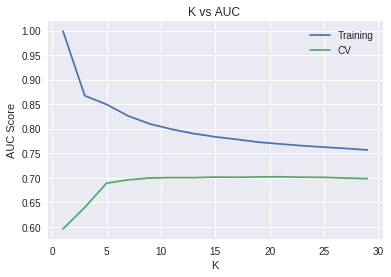

In [230]:
plt.plot(K,AUC_training,label='Training')
plt.plot(K,AUC_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('K')
plt.title('K vs AUC ')
plt.legend()
plt.show()

**Observation:** Optimal value of k=23  having AUC= 0.70

Train AUC =  0.765200601386901
Test AUC =  0.7032666631573867


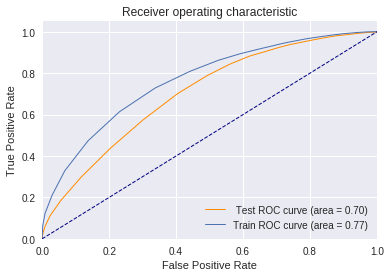

In [231]:
clf = KNeighborsClassifier(n_neighbors=23,algorithm='brute')
clf.fit(train_bows,y_train)

#Train Curve
y_pred_train=clf.predict_proba(train_bows)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

#Test Curve
y_pred=clf.predict_proba(test_bows)[:,1]
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)

#Drawing ROC curve
print('Train AUC = ',metrics.auc(fpr_train, tpr_train))
print('Test AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=' Test ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, lw=1, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [232]:
#Confusion_Matrices
y_pred_train=clf.predict(train_bows)
print("Confusion_Matrices Report for Train Data")
print(metrics.classification_report(y_train,y_pred_train))

y_pred=clf.predict(test_bows)
print("Confusion_Matrices Report for Test Data")
print(metrics.classification_report(y_test,y_pred))


Confusion_Matrices Report for Train Data
              precision    recall  f1-score   support

           0       0.70      0.41      0.52     19217
           1       0.72      0.89      0.79     31983

   micro avg       0.71      0.71      0.71     51200
   macro avg       0.71      0.65      0.66     51200
weighted avg       0.71      0.71      0.69     51200

Confusion_Matrices Report for Test Data
              precision    recall  f1-score   support

           0       0.66      0.38      0.48      6061
           1       0.70      0.88      0.78      9939

   micro avg       0.69      0.69      0.69     16000
   macro avg       0.68      0.63      0.63     16000
weighted avg       0.69      0.69      0.67     16000



In [0]:
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix_train = confusion_matrix(y_train,y_pred_train)
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
df_cm_train = pd.DataFrame(cnf_matrix_train, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])

Confusion Matrices for test Data


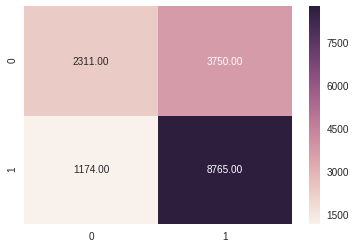

In [234]:
print("Confusion Matrices for test Data")
ax = sns.heatmap(df_cm,annot=True, fmt=".2f")

Confusion Matrices for Train Data


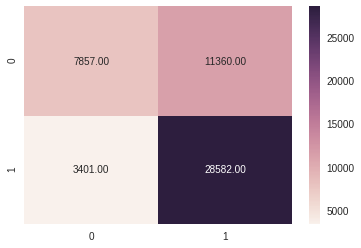

In [235]:
print("Confusion Matrices for Train Data")
ax_train = sns.heatmap(df_cm_train,annot=True, fmt=".2f")

# [5.2] Apply Knn(brute force version) on TFIDF

In [0]:
from time import time

In [242]:
start = time()
AUC_training=[]
AUC_cv=[]
K=[i for i in range(1,30,2)]
for i in K:
  clf=KNeighborsClassifier(n_neighbors=i,algorithm='brute' )
  clf.fit(train_tfidf,y_train)
  
  print("====== K = ",i," ===========")
  #Training Data
  y_predict_training=clf.predict_proba(train_tfidf)[:,1]
  auc=roc_auc_score(y_train,y_predict_training)
  AUC_training.append(auc)
  print("Train AUC = ",auc)
  
  #CV Curve
  y_predict_cv=clf.predict_proba(cv_tfidf)[:,1]
  auc=roc_auc_score(y_cv,y_predict_cv)
  AUC_cv.append(auc)
  print(" CV AUC = ",auc)
  
print("Time Taken= ",int((time()-start)/60)," Minutes")


====== K =  1  ===========
Train AUC =  0.9985461026170153
 CV AUC =  0.5073260980744811
====== K =  3  ===========
Train AUC =  0.9776345088984973
 CV AUC =  0.5169056380510271
====== K =  5  ===========
Train AUC =  0.7740043877482
 CV AUC =  0.5076284629143697
====== K =  7  ===========
Train AUC =  0.7365591383416144
 CV AUC =  0.5059043135024364
====== K =  9  ===========
Train AUC =  0.7130006406539369
 CV AUC =  0.5070146230961383
====== K =  11  ===========
Train AUC =  0.6951476713287692
 CV AUC =  0.505456291312184
====== K =  13  ===========
Train AUC =  0.6825098130045999
 CV AUC =  0.5125905521546119
====== K =  15  ===========
Train AUC =  0.6716507623717094
 CV AUC =  0.5123383258465036
====== K =  17  ===========
Train AUC =  0.6611345071600171
 CV AUC =  0.5144598870248452
====== K =  19  ===========
Train AUC =  0.6547312145264325
 CV AUC =  0.5181855404092184
====== K =  21  ===========
Train AUC =  0.6493077926013704
 CV AUC =  0.5168865526386683
====== K =  23  ===

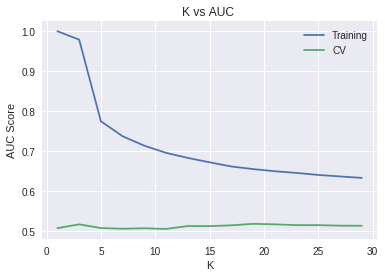

In [243]:
plt.plot(K,AUC_training,label='Training')
plt.plot(K,AUC_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('K')
plt.title('K vs AUC ')
plt.legend()
plt.show()

**Observation:** Opti,al value of K= 21 having AUC= 0.516

Train AUC =  0.6493077926013704
Test AUC =  0.5011037548481473


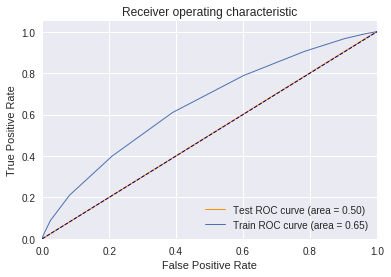

In [244]:
clf = KNeighborsClassifier(n_neighbors=21,algorithm='brute')
clf.fit(train_tfidf,y_train)
#Train Curve
y_pred_train=clf.predict_proba(train_tfidf)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
#Test Curve
y_pred=clf.predict(test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)
#Drawing ROC curve
print('Train AUC = ',metrics.auc(fpr_train, tpr_train))
print('Test AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, lw=1, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [246]:
#Confusion_Matrices

#Confusion_Matrices Report for Train Data
y_pred_train=clf.predict(train_tfidf)
print("Confusion_Matrices Report for Train Data")
print(metrics.classification_report(y_train,y_pred_train))

#Confusion_Matrices Report for Test Data
y_pred=clf.predict(test_tfidf)
print("Confusion_Matrices Report for Test Data")
print(metrics.classification_report(y_test,y_pred))


Confusion_Matrices Report for Train Data
              precision    recall  f1-score   support

           0       0.68      0.03      0.07     19217
           1       0.63      0.99      0.77     31983

   micro avg       0.63      0.63      0.63     51200
   macro avg       0.66      0.51      0.42     51200
weighted avg       0.65      0.63      0.51     51200

Confusion_Matrices Report for Test Data
              precision    recall  f1-score   support

           0       0.41      0.02      0.04      6061
           1       0.62      0.98      0.76      9939

   micro avg       0.62      0.62      0.62     16000
   macro avg       0.52      0.50      0.40     16000
weighted avg       0.54      0.62      0.49     16000



In [0]:
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix_train = confusion_matrix(y_train,y_pred_train)
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
df_cm_train = pd.DataFrame(cnf_matrix_train, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])

Confusion Matrices for test Data


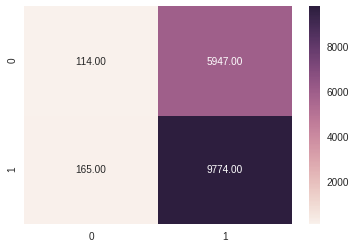

In [248]:
print("Confusion Matrices for test Data")
ax = sns.heatmap(df_cm,annot=True, fmt=".2f")

Confusion Matrices for Train Data


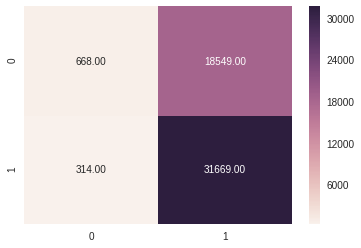

In [249]:
print("Confusion Matrices for Train Data")
ax_train = sns.heatmap(df_cm_train,annot=True, fmt=".2f")

# 5.1.3 Word2Vec

**Simple Cross Validation**

In [204]:
AUC_training=[]
AUC_cv=[]
K=[i for i in range(1,30,2)]
for i in K:
  clf=KNeighborsClassifier(n_neighbors=i,algorithm='brute' )
  clf.fit(sent_vectors,y_train)
  print("===K = ",i,"======")
  #Training Data
  y_predict_training=clf.predict_proba(sent_vectors)[:,1]
  auc=roc_auc_score(y_train,y_predict_training)
  AUC_training.append(auc)
  print("Train Auc = ",auc) 
  #CV Curve
  y_predict_cv=clf.predict_proba(sent_vectors_cv)[:,1]
  auc=roc_auc_score(y_cv,y_predict_cv)
  AUC_cv.append(auc)
  print("Test Auc = ",auc) 

===K =  1 ======
Train Auc =  0.9985461026170153
Test Auc =  0.5637056383446488
===K =  3 ======
Train Auc =  0.9563606499199305
Test Auc =  0.6532648271894559
===K =  5 ======
Train Auc =  0.9443639466575324
Test Auc =  0.7058695979762751
===K =  7 ======
Train Auc =  0.938235515302627
Test Auc =  0.7364955764313614
===K =  9 ======
Train Auc =  0.9339108356158878
Test Auc =  0.7555432898573933
===K =  11 ======
Train Auc =  0.9310162092066424
Test Auc =  0.7665824837441049
===K =  13 ======
Train Auc =  0.9289382145307
Test Auc =  0.7738000990763604
===K =  15 ======
Train Auc =  0.9269070685189341
Test Auc =  0.7801272803004253
===K =  17 ======
Train Auc =  0.9254934205717482
Test Auc =  0.7840536188930483
===K =  19 ======
Train Auc =  0.9243228743031613
Test Auc =  0.7882611396151394
===K =  21 ======
Train Auc =  0.9233195467219765
Test Auc =  0.7932755040095619
===K =  23 ======
Train Auc =  0.9225936381085759
Test Auc =  0.7960295185264299
===K =  25 ======
Train Auc =  0.9217

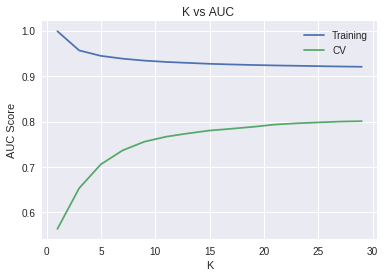

In [205]:
plt.plot(K,AUC_training,label='Training')
plt.plot(K,AUC_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('K')
plt.title('K vs AUC ')
plt.legend()
plt.show()

**Observation :** Optimal value of k is 15 (Not choosing 29 as 15 is more faster and also not much less AUC)

Train AUC =  0.9269070685189341
CV AUC =  0.7802127709269076


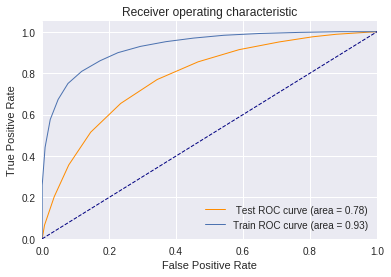

In [206]:
clf = KNeighborsClassifier(n_neighbors=15,algorithm='brute')
clf.fit(sent_vectors,y_train)

#Train Curve
y_pred_train=clf.predict_proba(sent_vectors)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

#Test Curve
y_pred=clf.predict_proba(sent_vectors_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)

#Drawing ROC curve
print('Train AUC = ',metrics.auc(fpr_train, tpr_train))
print('CV AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=' Test ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, lw=1, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [207]:
#Confusion_Matrices_Report
y_pred_train=clf.predict(sent_vectors)
print("Confusion_Matrices Report for Train Data")
print(metrics.classification_report(y_train,y_pred_train))

y_pred=clf.predict(sent_vectors_test)
print("Confusion_Matrices Report for Test Data")
print(metrics.classification_report(y_test,y_pred))


Confusion_Matrices Report for Train Data
              precision    recall  f1-score   support

           0       0.82      0.77      0.80     19217
           1       0.87      0.90      0.88     31983

   micro avg       0.85      0.85      0.85     51200
   macro avg       0.84      0.84      0.84     51200
weighted avg       0.85      0.85      0.85     51200

Confusion_Matrices Report for Test Data
              precision    recall  f1-score   support

           0       0.74      0.41      0.53      6061
           1       0.72      0.91      0.80      9939

   micro avg       0.72      0.72      0.72     16000
   macro avg       0.73      0.66      0.67     16000
weighted avg       0.73      0.72      0.70     16000



In [0]:
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix_train = confusion_matrix(y_train,y_pred_train)
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
df_cm_train = pd.DataFrame(cnf_matrix_train, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])

Confusion Matrices for test Data


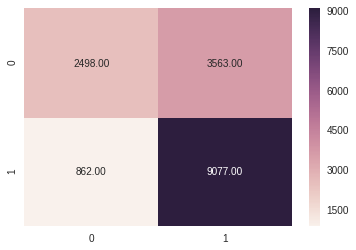

In [209]:
print("Confusion Matrices for test Data")
ax = sns.heatmap(df_cm,annot=True, fmt=".2f")

Confusion Matrices for Train Data


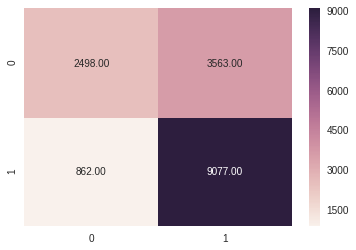

In [210]:
print("Confusion Matrices for Train Data")
ax_train = sns.heatmap(df_cm_train,annot=True, fmt=".2f")

# 5.1.4 KNN(brute force) on TFIDFW2Vec

In [219]:
AUC_training=[]
AUC_cv=[]
K=[i for i in range(1,30,2)]
for i in K:
  clf=KNeighborsClassifier(n_neighbors=i,algorithm='brute' )
  clf.fit(tfidf_sent_vectors_train,y_train)
  print("===K = ",i,"======")
  #Training Data
  y_predict_training=clf.predict_proba(tfidf_sent_vectors_train)[:,1]
  auc=roc_auc_score(y_train,y_predict_training)
  AUC_training.append(auc)
  print("Train Auc = ",auc) 
  #CV Curve
  y_predict_cv=clf.predict_proba(tfidf_sent_vectors_cv)[:,1]
  auc=roc_auc_score(y_cv,y_predict_cv)
  AUC_cv.append(auc)
  print("CV Auc = ",auc) 

===K =  1 ======
Train Auc =  0.9985461026170153
CV Auc =  0.5616636303033983
===K =  3 ======
Train Auc =  0.9462980265780376
CV Auc =  0.6297492003788979
===K =  5 ======
Train Auc =  0.929257470100773
CV Auc =  0.6673171960928594
===K =  7 ======
Train Auc =  0.9213467898889037
CV Auc =  0.6866655309797663
===K =  9 ======
Train Auc =  0.9156379033391724
CV Auc =  0.7033360619181112
===K =  11 ======
Train Auc =  0.9119666757970636
CV Auc =  0.7187589626721842
===K =  13 ======
Train Auc =  0.909506051969955
CV Auc =  0.7293525462614141
===K =  15 ======
Train Auc =  0.9066325818148002
CV Auc =  0.7382434122032757
===K =  17 ======
Train Auc =  0.9045603012636264
CV Auc =  0.7435463385947201
===K =  19 ======
Train Auc =  0.9030523011090392
CV Auc =  0.7494240033036639
===K =  21 ======
Train Auc =  0.9016931927906598
CV Auc =  0.7552561566446754
===K =  23 ======
Train Auc =  0.9001509558848075
CV Auc =  0.7603598659365133
===K =  25 ======
Train Auc =  0.8989709891200901
CV Auc = 

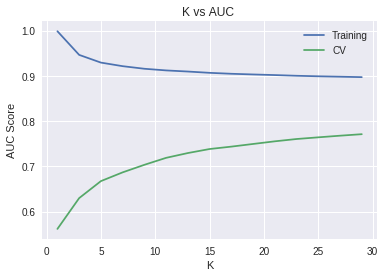

In [220]:
plt.plot(K,AUC_training,label='Training')
plt.plot(K,AUC_cv,label='CV')
plt.ylabel('AUC Score')
plt.xlabel('K')
plt.title('K vs AUC ')
plt.legend()
plt.show()

**Observation:** Optimal value of K=29

Train AUC =  0.8971042413414873
CV AUC =  0.7780028127027765


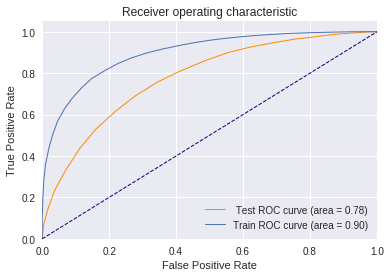

In [221]:
clf = KNeighborsClassifier(n_neighbors=29,algorithm='brute')
clf.fit(tfidf_sent_vectors_train,y_train)

#Train Curve
y_pred_train=clf.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

#Test Curve
y_pred=clf.predict_proba(tfidf_sent_vectors_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)

#Drawing ROC curve
print('Train AUC = ',metrics.auc(fpr_train, tpr_train))
print('CV AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=' Test ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, lw=1, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [222]:
#Confusion_Matrices_Report
y_pred_train=clf.predict(tfidf_sent_vectors_train)
print("Confusion_Matrices Report for Train Data")
print(metrics.classification_report(y_train,y_pred_train))

y_pred=clf.predict(tfidf_sent_vectors_test)
print("Confusion_Matrices Report for Test Data")
print(metrics.classification_report(y_test,y_pred))


Confusion_Matrices Report for Train Data
              precision    recall  f1-score   support

           0       0.80      0.69      0.74     19217
           1       0.83      0.90      0.86     31983

   micro avg       0.82      0.82      0.82     51200
   macro avg       0.81      0.79      0.80     51200
weighted avg       0.82      0.82      0.82     51200

Confusion_Matrices Report for Test Data
              precision    recall  f1-score   support

           0       0.78      0.31      0.44      6061
           1       0.69      0.95      0.80      9939

   micro avg       0.70      0.70      0.70     16000
   macro avg       0.74      0.63      0.62     16000
weighted avg       0.73      0.70      0.66     16000



In [0]:
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix_train = confusion_matrix(y_train,y_pred_train)
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
df_cm_train = pd.DataFrame(cnf_matrix_train, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])

Confusion Matrices for test Data


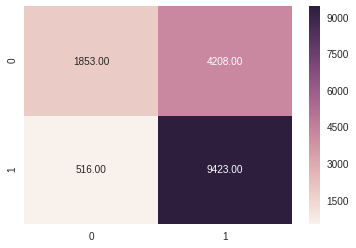

In [224]:
print("Confusion Matrices for test Data")
ax = sns.heatmap(df_cm,annot=True, fmt=".2f")

Confusion Matrices for Train Data


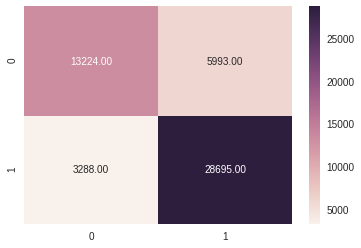

In [225]:
print("Confusion Matrices for Train Data")
ax_train = sns.heatmap(df_cm_train,annot=True, fmt=".2f")

# Conclusion:

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Algorithm", "K", "AUC"]
x.add_row(["BOWs","BruteForce", 23, 0.70])
x.add_row(["TFIDF","BruteForce", 500, 0.77])
x.add_row(["W2Vec","BruteForce", 15, 0.78])
x.add_row(["TFIDFW2Vec","BruteForce", 29, 0.78])
print (x)